# IOE 511 / MATH 562 Optimization Project

## Experiment Runner and Visualization


In [85]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os

import problems
import solver

print("Modules imported.")

Modules imported.


## 1. Define Problems and Methods

Define the set of problems and optimization methods to compare.

In [86]:
# List of problem names to test
problem_names = [
    'quad_10_10',
    'quad_10_1000',
    'quad_1000_10',
    'quad_1000_1000',
    'quartic_1',           
    'quartic_2',            
    'Rosenbrock_2',       
    'Rosenbrock_100',      
    'DataFit_2',            
    'Exponential_10',       
    'Exponential_1000',        
    'Genhumps_5',           
]

# Load problems
# Note: Ensure .mat files for quadratic problems are accessible (e.g., in the same directory)
test_problems = []
missing_files = False
for name in problem_names:
    try:
        # The get_problem function handles loading .mat files internally now
        problem_obj = problems.get_problem(name)
        test_problems.append(problem_obj.to_dict()) # Convert to dict for solver
    except FileNotFoundError as e:
        print(f"Warning: Could not load problem '{name}'. {e}. Skipping.")
        missing_files = True
    except Exception as e:
        print(f"Warning: Error loading problem '{name}': {e}. Skipping.")
        missing_files = True

if missing_files:
    print("\nEnsure the .mat files for quadratic problems are in the correct directory.")

# List of methods to test (using names expected by solver.py)
method_specs = [
    {'name': 'GradientDescent'},     # Backtracking 
    {'name': 'GradientDescentW'},    # Wolfe
    {'name': 'Newton'},              # Backtracking 
    {'name': 'NewtonW'},             # Wolfe 
    {'name': 'BFGS'},                # Backtracking 
    {'name': 'BFGSW'},               # Wolfe 
    {'name': 'DFP'},                 # Backtracking 
    {'name': 'DFPW'},                # Wolfe
    {'name': 'TRNewtonCG'},          # Trust Region Newton CG 
    {'name': 'TRSR1CG'},             # Trust Region SR1 CG 
    # L-BFGS Variants - Add memory size and strategy 
    {'name': 'LBFGS-M5-FIFO'},
    {'name': 'LBFGS-M5-MIN_CURV'},
    {'name': 'LBFGS-M5-ADAPTIVE'},
    {'name': 'LBFGS-M10-FIFO'},
    {'name': 'LBFGS-M10-MIN_CURV'},
    {'name': 'LBFGS-M10-ADAPTIVE'}
]

print(f"Loaded {len(test_problems)} problems.")
print(f"Defined {len(method_specs)} methods.")

Loaded 12 problems.
Defined 16 methods.


## 2. Define Options and Run Experiments

Set common optimization options and run the solver for each problem-method pair.

In [87]:
# Define common options
options = {
    # Regular trust region parameters
    'delta_init': 1.0,           # Initial trust region size
    'c1_tr': 0.5,                # TR contraction factor (higher = more conservative)
    'c2_tr': 1.5,                # TR expansion factor (lower = more conservative)
    
    # New parameters to control oscillation
    'delta_dampening': 0.8,      # Controls smoothness of TR changes (0.5-0.9)
    'sr1_reg_init': 1e-6,        # Initial regularization
    'sr1_reg_update': 1.2,       # How quickly regularization increases
    'strict_acceptance': True,    # Use stricter step acceptance
    'adaptive_tr': True,         # Enable adaptive trust region
}

# Store results
results = {}
detailed_info = {} # Store the full info dict for analysis

for problem in test_problems:
    problem_name = problem['name']
    print(f"\n--- Solving Problem: {problem_name} ---")
    results[problem_name] = {}
    detailed_info[problem_name] = {}
    
    for method in method_specs:
        method_name = method['name']
        print(f"  Using Method: {method_name}...")
        
        # Make a deep copy of options to avoid modification across runs if needed
        current_options = options.copy()
        
        # Make a copy of the problem dict to potentially reset x0 if necessary
        problem_instance = problem.copy()
        problem_instance['x0'] = problem['x0'].copy() # Ensure x0 is reset
        
        start_run_time = time.time()
        try:
            import copy
            # import time # Already imported at the top

            # --- Prepare arguments for solver.optSolver_WHY ---
            # 1. Method dictionary (containing the name)
            method_dict = {'name': method_name} # Uses method_name from the inner loop

            # 2. Options dictionary (Use the 'options' defined earlier in this cell)
            #    Make a deep copy to ensure options aren't changed between runs
            current_options = copy.deepcopy(options)
            # No method_options to update with based on Cell 4 definition

            # 3. Problem instance dictionary (already available as problem_instance)
            #    Ensuring x0 reset is already handled before the try block

            x_final, f_final, info = solver.optSolver_WHY(problem_instance, method_dict, current_options)

            end_run_time = time.time()
            run_time = end_run_time - start_run_time

            # --- Store Summary Results (for table) ---
            results[problem_name][method_name] = {
                'Iterations': info['iterations'],
                'Final f(x)': f_final,
                'Final ||∇f(x)||': info['grad_norms'][-1] if info.get('grad_norms') else 'N/A',
                'CPU Time (s)': run_time,
                'Success': info['success'],
                'Termination': info['termination_reason']
            }
            # Store full info for plotting
            detailed_info[problem_name][method_name] = info
            print(f"  Finished in {run_time:.4f} s, Iterations: {info['iterations']}, Success: {info['success']}")

        except Exception as e:
            # Capture runtime even on failure if possible before the error
            end_run_time = time.time()
            run_time = end_run_time - start_run_time
            print(f"  Failed: {e}") # Original error gets printed here

            # --- Store Failure Results ---
            results[problem_name][method_name] = {
                'Iterations': 'Error',
                'Final f(x)': 'Error',
                'Final ||∇f(x)||': 'Error',
                'CPU Time (s)': run_time, # Record time until failure
                'Success': False,
                'Termination': f'Failed with {type(e).__name__}'
            }
            detailed_info[problem_name][method_name] = {'termination_reason': str(e), 'success': False}

            



--- Solving Problem: quad_10_10 ---
  Using Method: GradientDescent...
  Finished in 0.0140 s, Iterations: 246, Success: True
  Using Method: GradientDescentW...
  Finished in 0.0030 s, Iterations: 52, Success: True
  Using Method: Newton...
  Finished in 0.0000 s, Iterations: 1, Success: True
  Using Method: NewtonW...
  Finished in 0.0005 s, Iterations: 3, Success: True
  Using Method: BFGS...
  Finished in 0.0220 s, Iterations: 242, Success: True
  Using Method: BFGSW...
  Finished in 0.0015 s, Iterations: 31, Success: True
  Using Method: DFP...
  Finished in 0.0010 s, Iterations: 42, Success: True
  Using Method: DFPW...
  Finished in 0.0010 s, Iterations: 42, Success: True
  Using Method: TRNewtonCG...
  Finished in 0.0330 s, Iterations: 1000, Success: False
  Using Method: TRSR1CG...
  Finished in 0.0546 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M5-FIFO...
  Finished in 0.0010 s, Iterations: 22, Success: True
  Using Method: LBFGS-M5-MIN_CURV...
  Finished in 0.

c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:182: RuntimeWarning: overflow encountered in matmul
  return 0.5 * (x.T @ x) + (sigma / 4.0) * (x.T @ Q @ x)**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:186: RuntimeWarning: overflow encountered in matmul
  q_term_scalar = x.T @ Q @ x
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:182: RuntimeWarning: invalid value encountered in matmul
  return 0.5 * (x.T @ x) + (sigma / 4.0) * (x.T @ Q @ x)**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:46: RuntimeWarning: invalid value encountered in scalar add
  if f_new <= f_x + c1 * alpha * dir_deriv:
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:186: RuntimeWarning: invalid value encountered in matmul
  q_term_scalar = x.T @ Q @ x
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:187: RuntimeWarning: invalid value encountered in ma

  Finished in 0.1176 s, Iterations: 1000, Success: False
  Using Method: DFP...
  Finished in 0.0205 s, Iterations: 1000, Success: False
  Using Method: DFPW...
  Finished in 0.1031 s, Iterations: 1000, Success: False
  Using Method: TRNewtonCG...
  Finished in 0.0010 s, Iterations: 12, Success: True
  Using Method: TRSR1CG...
  Finished in 0.0055 s, Iterations: 136, Success: True
  Using Method: LBFGS-M5-FIFO...
  Finished in 0.0005 s, Iterations: 26, Success: True
  Using Method: LBFGS-M5-MIN_CURV...
  Finished in 0.0175 s, Iterations: 453, Success: True
  Using Method: LBFGS-M5-ADAPTIVE...
  Finished in 0.0010 s, Iterations: 26, Success: True
  Using Method: LBFGS-M10-FIFO...
  Finished in 0.0010 s, Iterations: 25, Success: True
  Using Method: LBFGS-M10-MIN_CURV...
  Finished in 0.0010 s, Iterations: 30, Success: True
  Using Method: LBFGS-M10-ADAPTIVE...
  Finished in 0.0010 s, Iterations: 25, Success: True

--- Solving Problem: Rosenbrock_2 ---
  Using Method: GradientDescent...


c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:218: RuntimeWarning: overflow encountered in scalar power
  return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:228: RuntimeWarning: overflow encountered in scalar power
  g[0] = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:229: RuntimeWarning: overflow encountered in scalar power
  g[1] = 200 * (x[1] - x[0]**2)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:218: RuntimeWarning: invalid value encountered in scalar subtract
  return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:228: RuntimeWarning: invalid value encountered in scalar subtract
  g[0] = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:22

  Finished in 0.0015 s, Iterations: 48, Success: True
  Using Method: DFPW...
  Finished in 0.0010 s, Iterations: 35, Success: True
  Using Method: TRNewtonCG...
  Finished in 0.0460 s, Iterations: 1000, Success: False
  Using Method: TRSR1CG...
  Finished in 0.0065 s, Iterations: 212, Success: True
  Using Method: LBFGS-M5-FIFO...
  Finished in 0.0150 s, Iterations: 672, Success: True
  Using Method: LBFGS-M5-MIN_CURV...
  Finished in 0.0265 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M5-ADAPTIVE...
  Finished in 0.0345 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M10-FIFO...
  Finished in 0.0190 s, Iterations: 672, Success: True
  Using Method: LBFGS-M10-MIN_CURV...
  Finished in 0.0250 s, Iterations: 750, Success: True
  Using Method: LBFGS-M10-ADAPTIVE...
  Finished in 0.0215 s, Iterations: 673, Success: True

--- Solving Problem: Rosenbrock_100 ---
  Using Method: GradientDescent...
  Finished in 0.0010 s, Iterations: 6, Success: False
  Using Method: Gr

c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:221: RuntimeWarning: overflow encountered in square
  term2 = 100 * (x[1:] - x[:-1]**2)**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:220: RuntimeWarning: overflow encountered in square
  term1 = (1 - x[:-1])**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:231: RuntimeWarning: overflow encountered in square
  term_in_paren = x[1:] - x[:-1]**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:232: RuntimeWarning: overflow encountered in multiply
  g[:-1] = -2 * (1 - x[:-1]) - 400 * x[:-1] * term_in_paren
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:221: RuntimeWarning: invalid value encountered in subtract
  term2 = 100 * (x[1:] - x[:-1]**2)**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:231: RuntimeWarning: invalid value encountered in subtract
  term_in_paren = x[1:] - x[

  Finished in 0.1591 s, Iterations: 1000, Success: False
  Using Method: Newton...
  Finished in 115.2926 s, Iterations: 1000, Success: False
  Using Method: NewtonW...
  Finished in 118.0397 s, Iterations: 1000, Success: False
  Using Method: BFGS...
  Finished in 0.0030 s, Iterations: 10, Success: False
  Using Method: BFGSW...


c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:221: RuntimeWarning: overflow encountered in multiply
  term2 = 100 * (x[1:] - x[:-1]**2)**2
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:782: RuntimeWarning: overflow encountered in matmul
  ys = y @ s
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:782: RuntimeWarning: invalid value encountered in matmul
  ys = y @ s


  Finished in 0.2467 s, Iterations: 1000, Success: False
  Using Method: DFP...
  Finished in 0.0320 s, Iterations: 185, Success: False
  Using Method: DFPW...


c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:883: RuntimeWarning: overflow encountered in matmul
  ys = y @ s
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:886: RuntimeWarning: overflow encountered in matmul
  yHy = y @ Hy
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:886: RuntimeWarning: invalid value encountered in matmul
  yHy = y @ Hy
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:883: RuntimeWarning: invalid value encountered in matmul
  ys = y @ s
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:866: RuntimeWarning: invalid value encountered in matmul
  d = -H_inv @ grad_x


  Finished in 0.1727 s, Iterations: 1000, Success: False
  Using Method: TRNewtonCG...
  Finished in 112.5682 s, Iterations: 1000, Success: False
  Using Method: TRSR1CG...
  Finished in 0.0380 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M5-FIFO...
  Finished in 0.1576 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M5-MIN_CURV...
  Finished in 0.1807 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M5-ADAPTIVE...
  Finished in 0.1886 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M10-FIFO...
  Finished in 0.1952 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M10-MIN_CURV...
  Finished in 0.2152 s, Iterations: 1000, Success: False
  Using Method: LBFGS-M10-ADAPTIVE...
  Finished in 0.2341 s, Iterations: 1000, Success: False

--- Solving Problem: DataFit_2 ---
  Using Method: GradientDescent...
  Finished in 0.0015 s, Iterations: 5, Success: False
  Using Method: GradientDescentW...
  Finished in 0.0215 s, Iterations: 507, Success: 

c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:273: RuntimeWarning: overflow encountered in square
  return np.sum(residuals**2)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:284: RuntimeWarning: overflow encountered in multiply
  g[0] = np.sum(2 * residuals * dr_dx1)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:295: RuntimeWarning: overflow encountered in multiply
  g[1] = np.sum(2 * residuals * dr_dx2)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:42: RuntimeWarning: invalid value encountered in add
  x_new = x + alpha * d
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:56: RuntimeWarning: invalid value encountered in add
  grad_new = grad(x + alpha * d) # Recalculate grad just in case
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\algorithms.py:57: RuntimeWarning: invalid value encountered in add
  return alpha, func(x + alpha *

  Finished in 0.3833 s, Iterations: 1000, Success: False
  Using Method: BFGS...
  Finished in 0.0025 s, Iterations: 7, Success: False
  Using Method: BFGSW...
  Finished in 0.0020 s, Iterations: 17, Success: True
  Using Method: DFP...
  Finished in 0.0010 s, Iterations: 24, Success: True
  Using Method: DFPW...
  Finished in 0.0010 s, Iterations: 24, Success: True
  Using Method: TRNewtonCG...
  Finished in 0.0010 s, Iterations: 11, Success: True
  Using Method: TRSR1CG...
  Finished in 0.0030 s, Iterations: 68, Success: True
  Using Method: LBFGS-M5-FIFO...
  Finished in 0.0005 s, Iterations: 12, Success: True
  Using Method: LBFGS-M5-MIN_CURV...
  Finished in 0.0010 s, Iterations: 21, Success: True
  Using Method: LBFGS-M5-ADAPTIVE...
  Finished in 0.0005 s, Iterations: 13, Success: True
  Using Method: LBFGS-M10-FIFO...
  Finished in 0.0005 s, Iterations: 12, Success: True
  Using Method: LBFGS-M10-MIN_CURV...
  Finished in 0.0005 s, Iterations: 12, Success: True
  Using Method: L

c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:272: RuntimeWarning: overflow encountered in power
  residuals = y - x[0] * (1 - x[1]**i_vals)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:272: RuntimeWarning: overflow encountered in multiply
  residuals = y - x[0] * (1 - x[1]**i_vals)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:280: RuntimeWarning: overflow encountered in power
  residuals = y - x[0] * (1 - x[1]**i_vals)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:280: RuntimeWarning: overflow encountered in multiply
  residuals = y - x[0] * (1 - x[1]**i_vals)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:283: RuntimeWarning: overflow encountered in power
  dr_dx1 = -(1 - x[1]**i_vals)
c:\Users\will\iCloudDrive\Documents\U-M\ioe_511\project_final\problems.py:294: RuntimeWarning: overflow encountered in power
  dr_dx2 = x[0] * i_vals * x[1]**(i_v

  Finished in 1.5374 s, Iterations: 1000, Success: False
  Using Method: BFGS...
  Finished in 0.0170 s, Iterations: 180, Success: True
  Using Method: BFGSW...
  Finished in 0.0020 s, Iterations: 20, Success: True
  Using Method: DFP...
  Finished in 0.0245 s, Iterations: 1000, Success: False
  Using Method: DFPW...
  Finished in 0.0395 s, Iterations: 1000, Success: False
  Using Method: TRNewtonCG...
  Finished in 0.1306 s, Iterations: 104, Success: True
  Using Method: TRSR1CG...
  Finished in 0.0050 s, Iterations: 118, Success: True
  Using Method: LBFGS-M5-FIFO...
  Finished in 0.0010 s, Iterations: 15, Success: True
  Using Method: LBFGS-M5-MIN_CURV...
  Finished in 0.0005 s, Iterations: 15, Success: True
  Using Method: LBFGS-M5-ADAPTIVE...
  Finished in 0.0005 s, Iterations: 15, Success: True
  Using Method: LBFGS-M10-FIFO...
  Finished in 0.0005 s, Iterations: 15, Success: True
  Using Method: LBFGS-M10-MIN_CURV...
  Finished in 0.0005 s, Iterations: 15, Success: True
  Using 

## 3. Results Summary Table

Display the summary results in a table as requested.

In [88]:
# --- Create Summary Table --- 
summary_data = []
method_names_list = [m['name'] for m in method_specs]

for prob_name in results:
    for meth_name in method_names_list:
        if meth_name in results[prob_name]:
            res = results[prob_name][meth_name]
            # Format results for display
            iter_disp = res['Iterations']
            f_disp = f"{res['Final f(x)']:.4e}" if isinstance(res['Final f(x)'], (int, float)) else 'Fail'
            norm_disp = f"{res['Final ||∇f(x)||']:.4e}" if isinstance(res['Final ||∇f(x)||'], (int, float)) else 'Fail'
            time_disp = f"{res['CPU Time (s)']:.4f}" if isinstance(res['CPU Time (s)'], (int, float)) else 'Fail'
            success_disp = 'Yes' if res['Success'] else 'No'
            
            summary_data.append({
                'Problem': prob_name,
                'Method': meth_name,
                'Iterations': iter_disp,
                'Final f(x)': f_disp,
                'Final ||∇f(x)||': norm_disp,
                'CPU Time (s)': time_disp,
                'Success': success_disp
            })
        else:
             # Handle cases where a method might not have results for a problem
             summary_data.append({
                'Problem': prob_name,
                'Method': meth_name,
                'Iterations': 'N/A',
                'Final f(x)': 'N/A',
                'Final ||∇f(x)||': 'N/A',
                'CPU Time (s)': 'N/A',
                'Success': 'N/A'
            })

# Create DataFrame for better display
# Ensure display is imported if running outside a standard Jupyter environment
try:
    from IPython.display import display
except ImportError:
    display = print # Fallback to print if display is not available
summary_df = pd.DataFrame(summary_data)
summary_df.set_index(['Problem', 'Method'], inplace=True)

# Display the table
print("--- Summary of Results ---")
display(summary_df)

--- Summary of Results ---


Iterations   Final f(x) Final ||∇f(x)||  \
Problem    Method                                                        
quad_10_10 GradientDescent            246  -2.4709e+01      9.5072e-07   
           GradientDescentW            52  -2.4709e+01      9.8342e-07   
           Newton                       1  -2.4709e+01      7.0066e-16   
           NewtonW                      3  -2.4709e+01      3.8183e-16   
           BFGS                       242  -2.4709e+01      9.5255e-07   
...                                   ...          ...             ...   
Genhumps_5 LBFGS-M5-MIN_CURV           22   1.8120e-12      7.8619e-07   
           LBFGS-M5-ADAPTIVE           24   4.9769e-13      3.8928e-07   
           LBFGS-M10-FIFO              30   1.2237e-13      1.6737e-07   
           LBFGS-M10-MIN_CURV         103   2.5344e-12      9.8764e-07   
           LBFGS-M10-ADAPTIVE          28   2.2105e-12      8.0229e-07   

                              CPU Time (s) Success  
Problem    Method                                   
quad_10_10 GradientDescent          0.0140     Yes  
           GradientDescentW         0.0030     Yes  
           Newton                   0.0000     Yes  
           NewtonW                  0.0005     Yes  
           BFGS                     0.0220     Yes  
...                                    ...     ...  
Genhumps_5 LBFGS-M5-MIN_CURV        0.0010     Yes  
           LBFGS-M5-ADAPTIVE        0.0010     Yes  
           LBFGS-M10-FIFO           0.0015     Yes  
           LBFGS-M10-MIN_CURV       0.0060     Yes  
           LBFGS-M10-ADAPTIVE       0.0015     Yes  

[192 rows x 5 columns]

In [89]:
reshaped_df = summary_df.unstack('Method')

# --- Save to CSV ---
# Define the output filename
output_filename = 'output_summary.csv'
# Save the reshaped DataFrame to a CSV file
# The MultiIndex columns will be handled appropriately by to_csv
reshaped_df.to_csv(output_filename)

print(f"Reshaped DataFrame saved to {output_filename}")
print("\nPreview of the reshaped DataFrame:")
# Display the first few rows of the reshaped DataFrame
# Use display() if in a Jupyter environment, otherwise print()
try:
    from IPython.display import display
    display(reshaped_df.head())
except ImportError:
    print(reshaped_df.head())

PermissionError: [Errno 13] Permission denied: 'output_summary.csv'

In [74]:
print("\nUnique values in Problem level:", summary_df.index.get_level_values('Problem').unique())
print("\nUnique values in Method level:", summary_df.index.get_level_values('Method').unique())


Unique values in Problem level: Index(['quad_10_10', 'quad_10_1000', 'quad_1000_10', 'quad_1000_1000',
       'P5_quartic_1', 'P6_quartic_2', 'Rosenbrock_2', 'Rosenbrock_100',
       'DataFit_2', 'Exponential_10', 'Exponential_1000', 'Genhumps_5'],
      dtype='object', name='Problem')

Unique values in Method level: Index(['GradientDescent', 'GradientDescentW', 'Newton', 'NewtonW', 'BFGS',
       'BFGSW', 'DFP', 'DFPW', 'TRNewtonCG', 'TRSR1CG', 'LBFGS-M5-FIFO',
       'LBFGS-M5-MIN_CURV', 'LBFGS-M5-ADAPTIVE', 'LBFGS-M10-FIFO',
       'LBFGS-M10-MIN_CURV', 'LBFGS-M10-ADAPTIVE'],
      dtype='object', name='Method')


In [92]:
summary_df.loc['P6_quartic_2']

Iterations  Final f(x) Final ||∇f(x)|| CPU Time (s)  \
Method                                                                    
GradientDescent              5         nan             nan       0.0010   
GradientDescentW          1000  1.4136e+05      4.4118e+05       0.0861   
Newton                      12  6.2979e-15      1.1223e-07       0.0005   
NewtonW                     26  7.5343e-23      1.2275e-11       0.0005   
BFGS                         5         nan             nan       0.0010   
BFGSW                     1000  1.4136e+05      4.4118e+05       0.1176   
DFP                       1000  1.7093e-07      5.9660e-04       0.0205   
DFPW                      1000  1.4136e+05      4.4118e+05       0.1031   
TRNewtonCG                  12  3.2836e-14      2.5627e-07       0.0010   
TRSR1CG                    136  3.5064e-13      8.3743e-07       0.0055   
LBFGS-M5-FIFO               26  3.1102e-15      7.8869e-08       0.0005   
LBFGS-M5-MIN_CURV          453  4.9160e-13      9.9156e-07       0.0175   
LBFGS-M5-ADAPTIVE           26  3.1102e-15      7.8869e-08       0.0010   
LBFGS-M10-FIFO              25  6.7262e-14      3.6677e-07       0.0010   
LBFGS-M10-MIN_CURV          30  4.9215e-13      9.9212e-07       0.0010   
LBFGS-M10-ADAPTIVE          25  6.7262e-14      3.6677e-07       0.0010   

                   Success  
Method                      
GradientDescent         No  
GradientDescentW        No  
Newton                 Yes  
NewtonW                Yes  
BFGS                    No  
BFGSW                   No  
DFP                     No  
DFPW                    No  
TRNewtonCG             Yes  
TRSR1CG                Yes  
LBFGS-M5-FIFO          Yes  
LBFGS-M5-MIN_CURV      Yes  
LBFGS-M5-ADAPTIVE      Yes  
LBFGS-M10-FIFO         Yes  
LBFGS-M10-MIN_CURV     Yes  
LBFGS-M10-ADAPTIVE     Yes

--- Aggregated Statistics per Method (Success based on ||∇f(x)|| < 1.0e-06) ---


CPUMean  CPUMedian  IterMean  IterMedian  SuccessRate  \
Method                                                                    
BFGS               14.784      0.028   335.917       230.5        0.583   
BFGSW              20.968      0.004   350.250        34.0        0.667   
DFP                 0.694      0.022   447.833       123.5        0.500   
DFPW                0.683      0.035   514.333       531.0        0.500   
GradientDescent     0.129      0.004   234.583        37.5        0.333   
GradientDescentW    0.342      0.058   718.167      1000.0        0.333   
Newton              9.655      0.002   102.333         7.0        0.833   
NewtonW            10.237      0.192   338.500        13.5        0.583   
TRNewtonCG          9.532      0.040   524.917       584.5        0.417   
TRSR1CG             0.655      0.006   416.417       174.0        0.583   

                 Success Rate  
Method                         
BFGS                    58.3%  
BFGSW                   66.7%  
DFP                     50.0%  
DFPW                    50.0%  
GradientDescent         33.3%  
GradientDescentW        33.3%  
Newton                  83.3%  
NewtonW                 58.3%  
TRNewtonCG              41.7%  
TRSR1CG                 58.3%

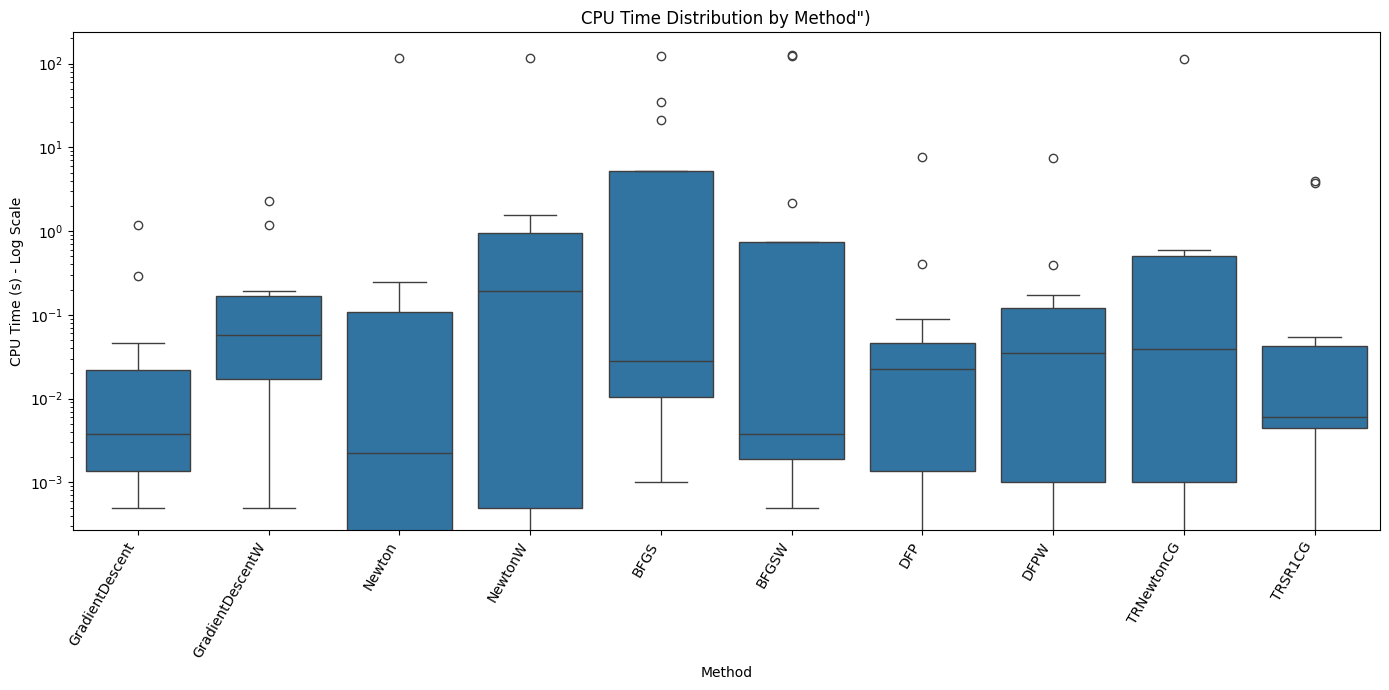

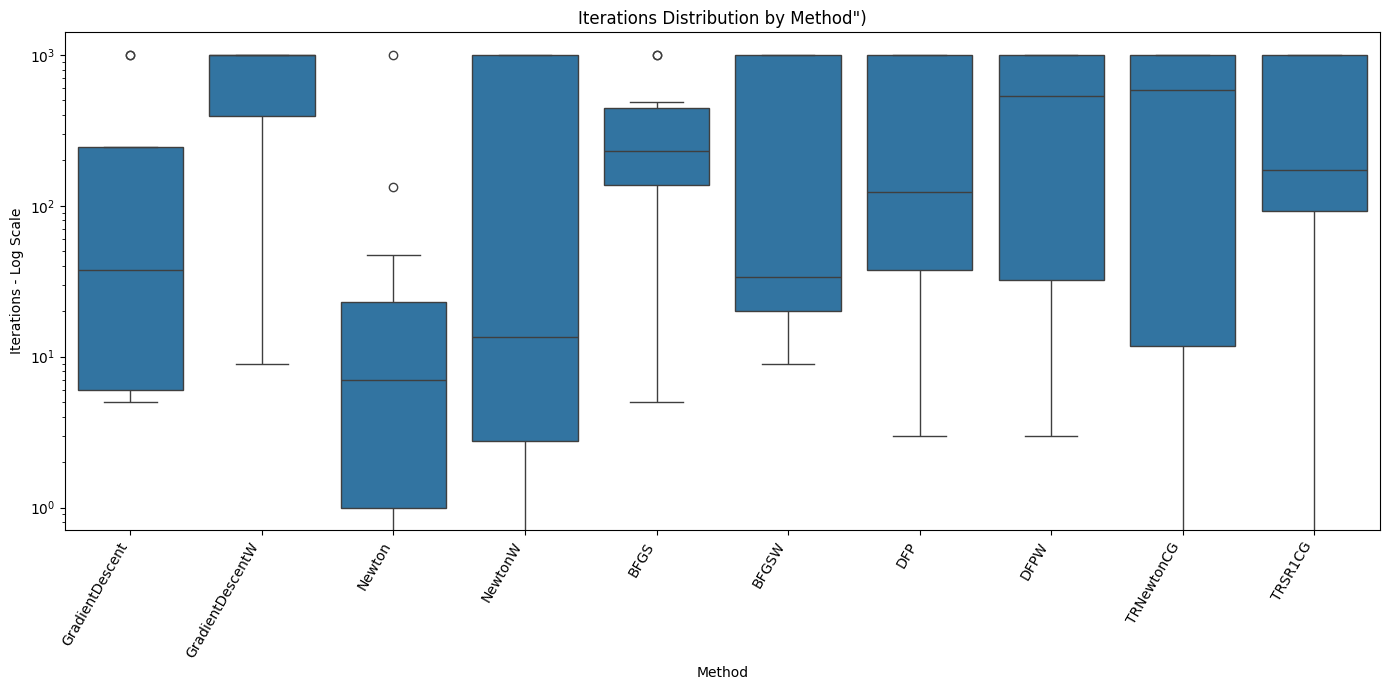

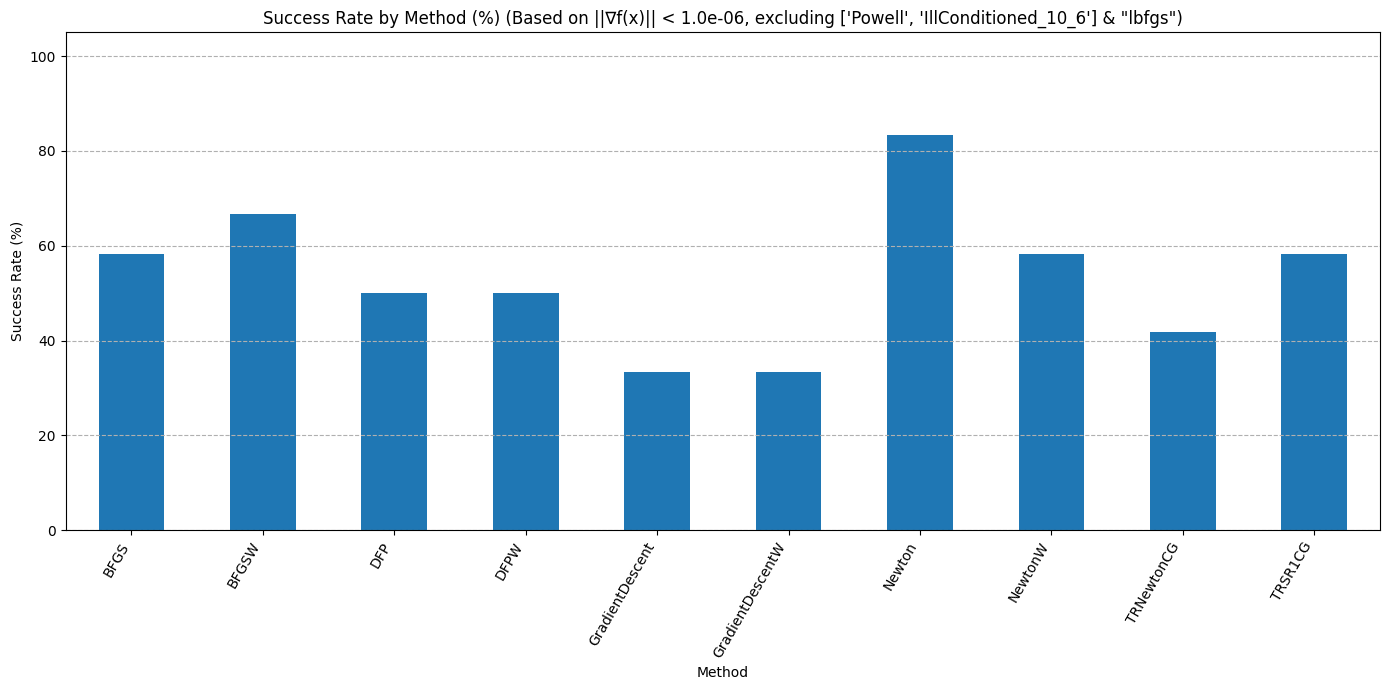

In [93]:
summary_df['CPU Time (s)'] = pd.to_numeric(summary_df['CPU Time (s)'], errors='coerce')
summary_df['Iterations'] = pd.to_numeric(summary_df['Iterations'], errors='coerce')
# Convert Final Gradient Norm to numeric, coercing errors (like 'Fail', 'N/A') to NaN
summary_df['FinalGradNorm'] = pd.to_numeric(summary_df['Final ||∇f(x)||'], errors='coerce')

# --- CORRECTED Success Calculation based DIRECTLY on Gradient Norm ---
# Define the tolerance
tolerance = 1e-6
# Create SuccessNumeric: 1 if FinalGradNorm < tolerance, 0 otherwise
# Handle NaN values in FinalGradNorm (treat them as failure/0)
summary_df['SuccessNumeric'] = (summary_df['FinalGradNorm'] < tolerance).fillna(False).astype(int)

# --- Filtering Step ---
problems_to_exclude = ['Powell', 'IllConditioned_10_6']
methods_to_exclude_keyword = 'lbfgs' # Keyword to identify methods to exclude

# Create mask for problems to include
problems_to_include_mask = ~summary_df.index.get_level_values('Problem').isin(problems_to_exclude)
# Create mask for methods to include (methods NOT containing the keyword)
methods_to_include_mask = ~summary_df.index.get_level_values('Method').str.contains(methods_to_exclude_keyword, case=False, na=False)

# Combine the masks using logical AND (&)
combined_mask = problems_to_include_mask & methods_to_include_mask

# Apply the combined filter
filtered_summary_df = summary_df[combined_mask]

# --- Calculate statistics using the FILTERED data ---
# Group by 'Method' from the filtered DataFrame
stats_df = filtered_summary_df.groupby('Method').agg(
    CPUMean=('CPU Time (s)', lambda x: x.dropna().mean()),
    CPUMedian=('CPU Time (s)', lambda x: x.dropna().median()),
    IterMean=('Iterations', lambda x: x.dropna().mean()),
    IterMedian=('Iterations', lambda x: x.dropna().median()),
    SuccessRate=('SuccessNumeric', 'mean') # Mean of 1s and 0s is the success rate
).round(3)

# Check if stats_df is empty after filtering
if stats_df.empty:
    print("Warning: No data left after filtering for problems and methods. Cannot generate statistics or plots.")
else:
    # --- Formatting and Display ---
    # Convert success rate column (named 'SuccessRate' by the agg function) to percentage string
    stats_df['Success Rate'] = (stats_df['SuccessRate'] * 100).round(1).astype(str) + '%'

    # Display the statistics table
    print(f"--- Aggregated Statistics per Method (Success based on ||∇f(x)|| < {tolerance:.1e}) ---")
    display(stats_df)


    # --- Visualization Code (Using Filtered Data) ---
    # Use the filtered data for plotting consistency
    plot_df = filtered_summary_df.dropna(subset=['CPU Time (s)', 'Iterations']).reset_index()

    if not plot_df.empty:
        # CPU Time boxplot
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='Method', y='CPU Time (s)', data=plot_df)
        plt.title(f'CPU Time Distribution by Method")')
        plt.ylabel('CPU Time (s) - Log Scale')
        plt.yscale('log') # Keep log scale if appropriate for your data range
        plt.xticks(rotation=60, ha='right')
        plt.tight_layout()
        plt.show()

        # Iterations boxplot
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='Method', y='Iterations', data=plot_df)
        plt.title(f'Iterations Distribution by Method")')
        plt.ylabel('Iterations - Log Scale')
        plt.yscale('log') # Keep log scale if appropriate for your data range
        plt.xticks(rotation=60, ha='right')
        plt.tight_layout()
        plt.show()

        # Success rate bar chart
        # Recalculate from stats_df in case formatting caused issues
        success_rates_numeric = stats_df['Success Rate'].str.replace('%', '').astype(float)
        plt.figure(figsize=(14, 7))
        success_rates_numeric.plot(kind='bar')
        plt.title(f'Success Rate by Method (%) (Based on ||∇f(x)|| < {tolerance:.1e}, excluding {problems_to_exclude} & "{methods_to_exclude_keyword}")')
        plt.ylabel('Success Rate (%)')
        plt.ylim(0, 105)
        plt.xticks(rotation=60, ha='right')
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: No valid data points left for plotting after filtering and dropping NaNs.")


In [18]:
summary_df.loc['quad_10_1000']

Iterations   Final f(x) Final ||∇f(x)||  CPU Time (s)  \
Method                                                                      
GradientDescent           1000  -6.7291e+02      1.6098e-01        0.0435   
GradientDescentW          1000  -6.7356e+02      1.3039e-02        0.0395   
Newton                       1  -6.7363e+02      3.5092e-15        0.0000   
NewtonW                      1  -6.7363e+02      3.5092e-15        0.0005   
BFGS                       429  -6.7363e+02      9.9350e-07        0.0310   
BFGSW                       47  -6.7363e+02      9.7490e-07        0.0035   
DFP                       1000  -6.7326e+02      5.9716e-01        0.0190   
DFPW                      1000  -6.7326e+02      5.9716e-01        0.0185   
TRNewtonCG                 169  -6.7363e+02      9.1306e-10        0.0045   
TRSR1CG                    101  -6.7363e+02      1.8992e-12        0.0050   
LBFGS-M5-FIFO              317  -6.7363e+02      9.9744e-07        0.0090   
LBFGS-M5-MIN_CURV          161  -6.7363e+02      9.7406e-07        0.0050   
LBFGS-M5-ADAPTIVE          160  -6.7363e+02      9.8963e-07        0.0045   
LBFGS-M10-FIFO              90  -6.7363e+02      9.8406e-07        0.0040   
LBFGS-M10-MIN_CURV         368  -6.7363e+02      9.9851e-07        0.0160   
LBFGS-M10-ADAPTIVE         111  -6.7363e+02      9.9350e-07        0.0055   

                    Success  
Method                       
GradientDescent        True  
GradientDescentW       True  
Newton                 True  
NewtonW                True  
BFGS                   True  
BFGSW                  True  
DFP                    True  
DFPW                   True  
TRNewtonCG             True  
TRSR1CG                True  
LBFGS-M5-FIFO          True  
LBFGS-M5-MIN_CURV      True  
LBFGS-M5-ADAPTIVE      True  
LBFGS-M10-FIFO         True  
LBFGS-M10-MIN_CURV     True  
LBFGS-M10-ADAPTIVE     True

In [10]:
summary_df.loc['quad_10_10']

Iterations   Final f(x) Final ||∇f(x)||  CPU Time (s)  \
Method                                                                      
GradientDescent            246  -2.4709e+01      9.5072e-07        0.0130   
GradientDescentW            52  -2.4709e+01      9.8342e-07        0.0020   
Newton                       1  -2.4709e+01      7.0066e-16        0.0005   
NewtonW                      3  -2.4709e+01      3.8183e-16        0.0000   
BFGS                       242  -2.4709e+01      9.5255e-07        0.0205   
BFGSW                       31  -2.4709e+01      8.3588e-07        0.0020   
DFP                         42  -2.4709e+01      9.3873e-07        0.0005   
DFPW                        42  -2.4709e+01      9.3873e-07        0.0010   
TRNewtonCG                1000  -2.4705e+01      5.7880e-02        0.0360   
TRSR1CG                   1000  -2.4709e+01      6.0924e-03        0.0495   
LBFGS-M5-FIFO               22  -2.4709e+01      6.4937e-07        0.0010   
LBFGS-M5-MIN_CURV           26  -2.4709e+01      7.2922e-07        0.0010   
LBFGS-M5-ADAPTIVE           19  -2.4709e+01      3.1958e-07        0.0005   
LBFGS-M10-FIFO              17  -2.4709e+01      9.9717e-07        0.0005   
LBFGS-M10-MIN_CURV          18  -2.4709e+01      1.9027e-07        0.0005   
LBFGS-M10-ADAPTIVE          18  -2.4709e+01      8.8959e-07        0.0010   

                    Success  
Method                       
GradientDescent        True  
GradientDescentW       True  
Newton                 True  
NewtonW                True  
BFGS                   True  
BFGSW                  True  
DFP                    True  
DFPW                   True  
TRNewtonCG             True  
TRSR1CG                True  
LBFGS-M5-FIFO          True  
LBFGS-M5-MIN_CURV      True  
LBFGS-M5-ADAPTIVE      True  
LBFGS-M10-FIFO         True  
LBFGS-M10-MIN_CURV     True  
LBFGS-M10-ADAPTIVE     True

In [21]:
summary_df.loc['Exponential_1000']

Iterations   Final f(x) Final ||∇f(x)||  CPU Time (s)  \
Method                                                                      
GradientDescent              9          nan             nan        0.0030   
GradientDescentW          1000  -2.0557e-01      1.9026e-05        0.2120   
Newton                       0   9.9950e+02      1.2643e+02        0.0000   
NewtonW                      0   9.9950e+02      1.2643e+02        0.0000   
BFGS                       184  -2.0557e-01      9.7572e-07       21.2981   
BFGSW                       20  -2.0557e-01      1.9231e-07        2.3256   
DFP                         10  -2.0557e-01      4.6597e-09        0.0630   
DFPW                         6  -2.0557e-01      3.3804e-07        0.0435   
TRNewtonCG                   0   9.9950e+02      1.2643e+02        0.0000   
TRSR1CG                      0   9.9950e+02      1.2643e+02        0.0000   
LBFGS-M5-FIFO               15  -2.0557e-01      8.9186e-09        0.0010   
LBFGS-M5-MIN_CURV           15  -2.0557e-01      8.9186e-09        0.0010   
LBFGS-M5-ADAPTIVE           15  -2.0557e-01      8.9186e-09        0.0010   
LBFGS-M10-FIFO              15  -2.0557e-01      8.9186e-09        0.0010   
LBFGS-M10-MIN_CURV          15  -2.0557e-01      8.9186e-09        0.0005   
LBFGS-M10-ADAPTIVE          15  -2.0557e-01      8.9186e-09        0.0010   

                    Success  
Method                       
GradientDescent        True  
GradientDescentW       True  
Newton                 True  
NewtonW                True  
BFGS                   True  
BFGSW                  True  
DFP                    True  
DFPW                   True  
TRNewtonCG             True  
TRSR1CG                True  
LBFGS-M5-FIFO          True  
LBFGS-M5-MIN_CURV      True  
LBFGS-M5-ADAPTIVE      True  
LBFGS-M10-FIFO         True  
LBFGS-M10-MIN_CURV     True  
LBFGS-M10-ADAPTIVE     True

## 4. Performance Visualization

Plot convergence graphs and performance profiles.

In [82]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import plot_convergence, calculate_performance_ratios, plot_profiles

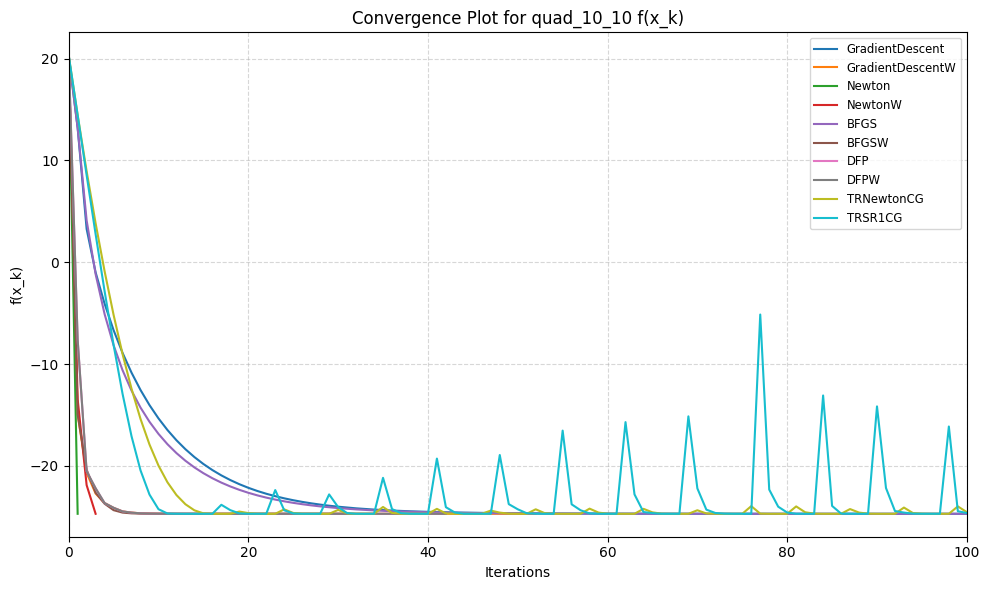

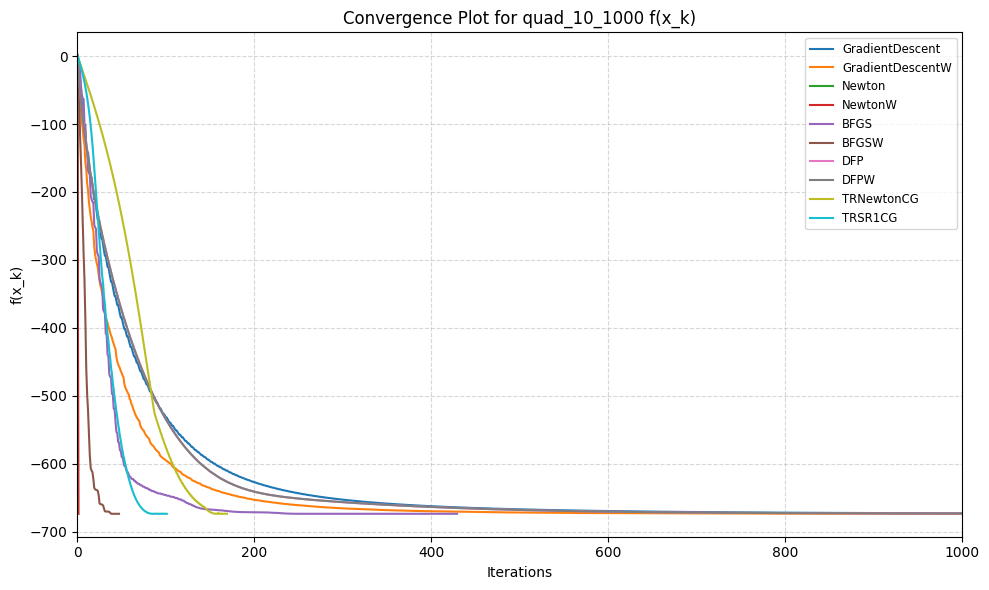

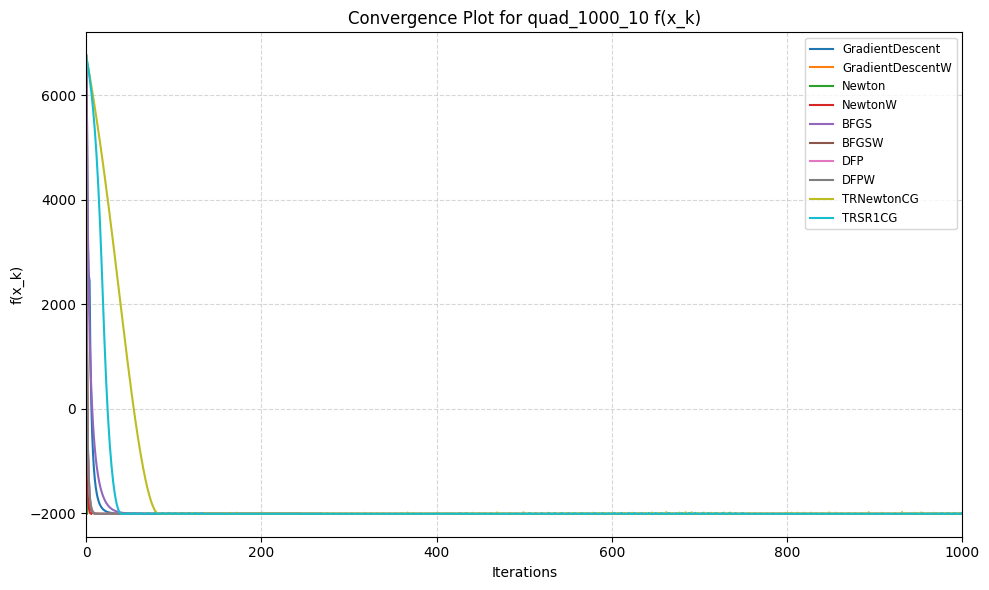

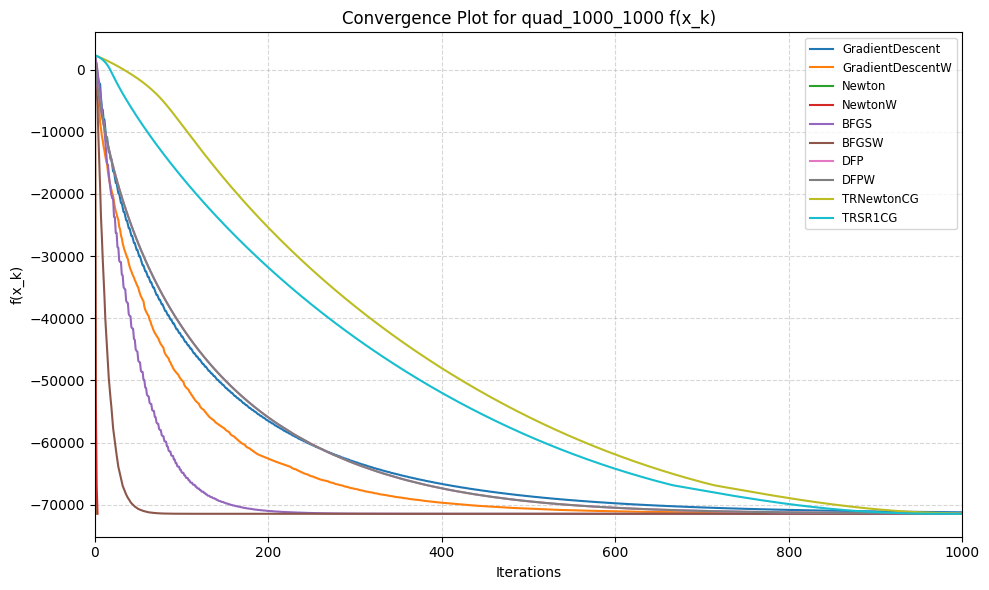

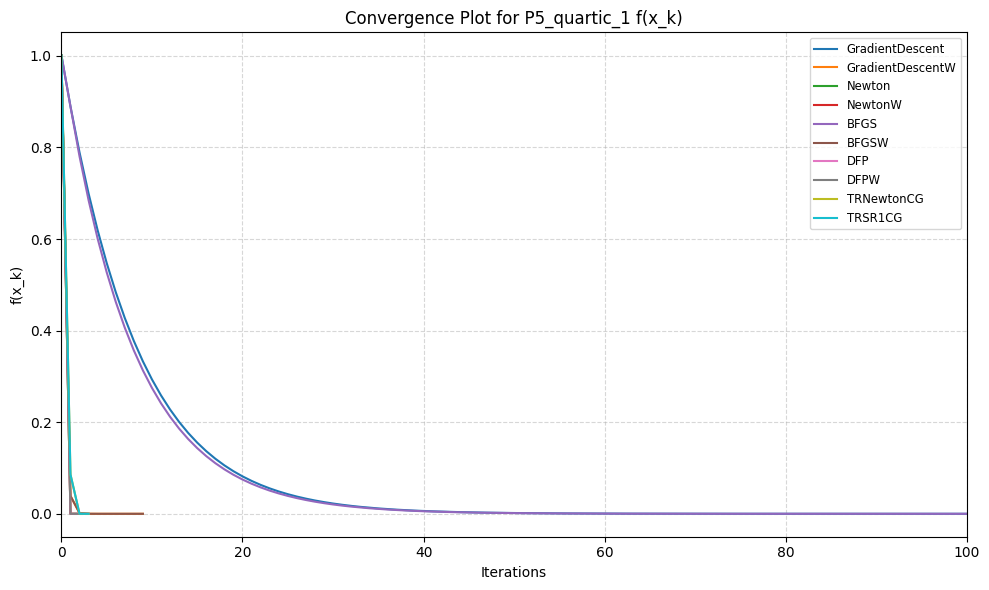

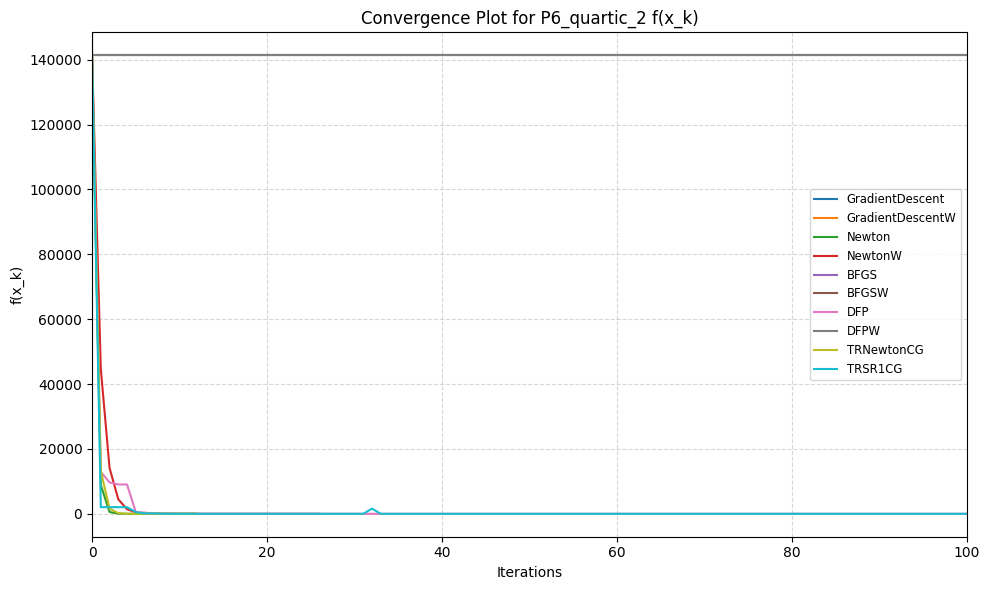

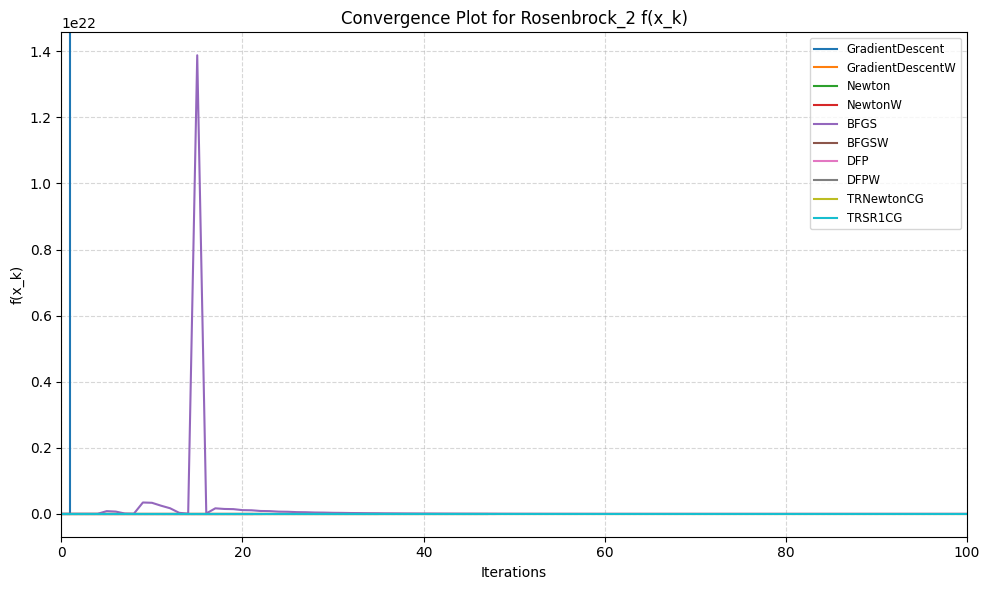

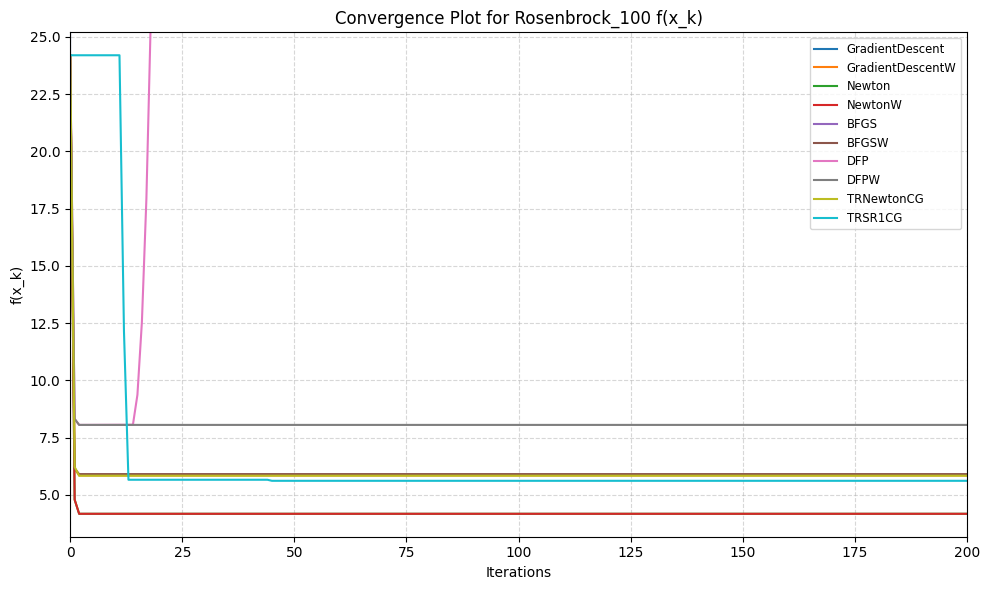

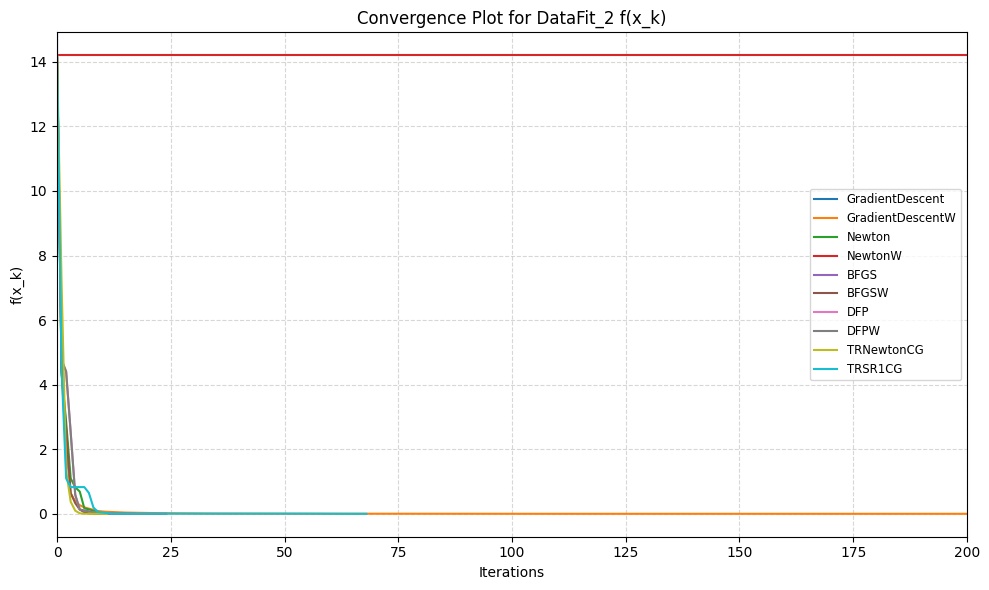

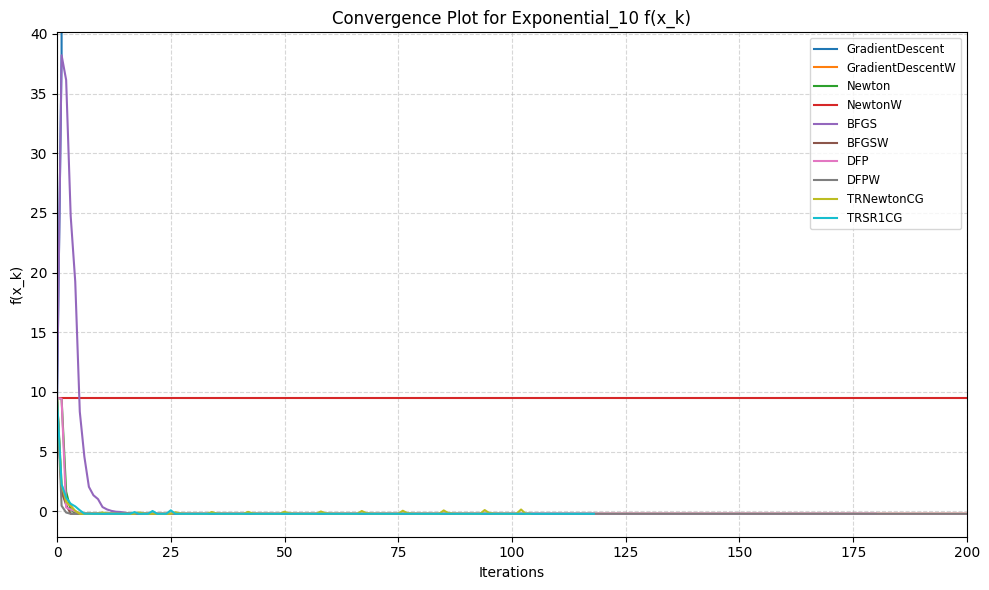

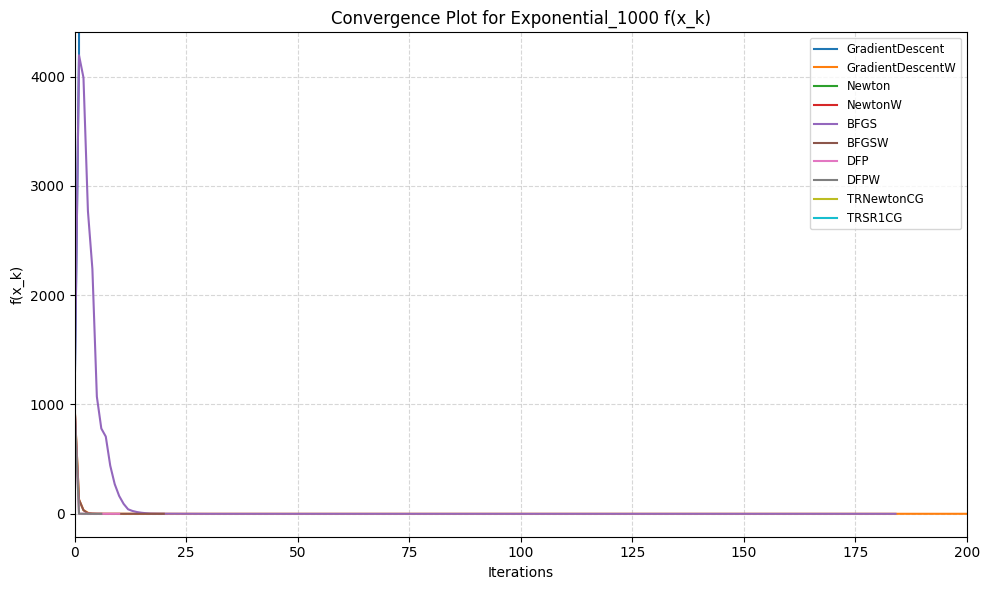

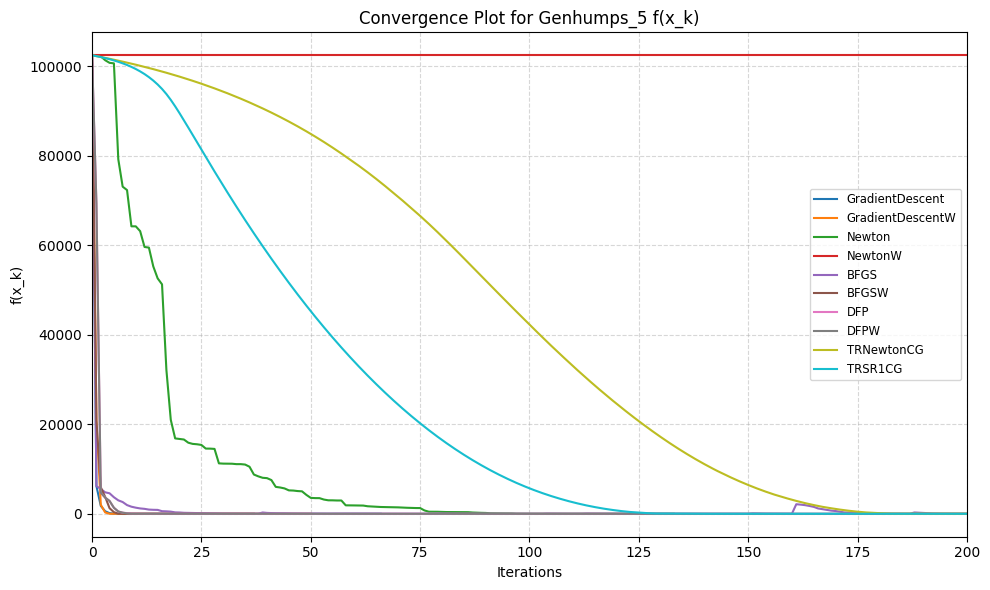

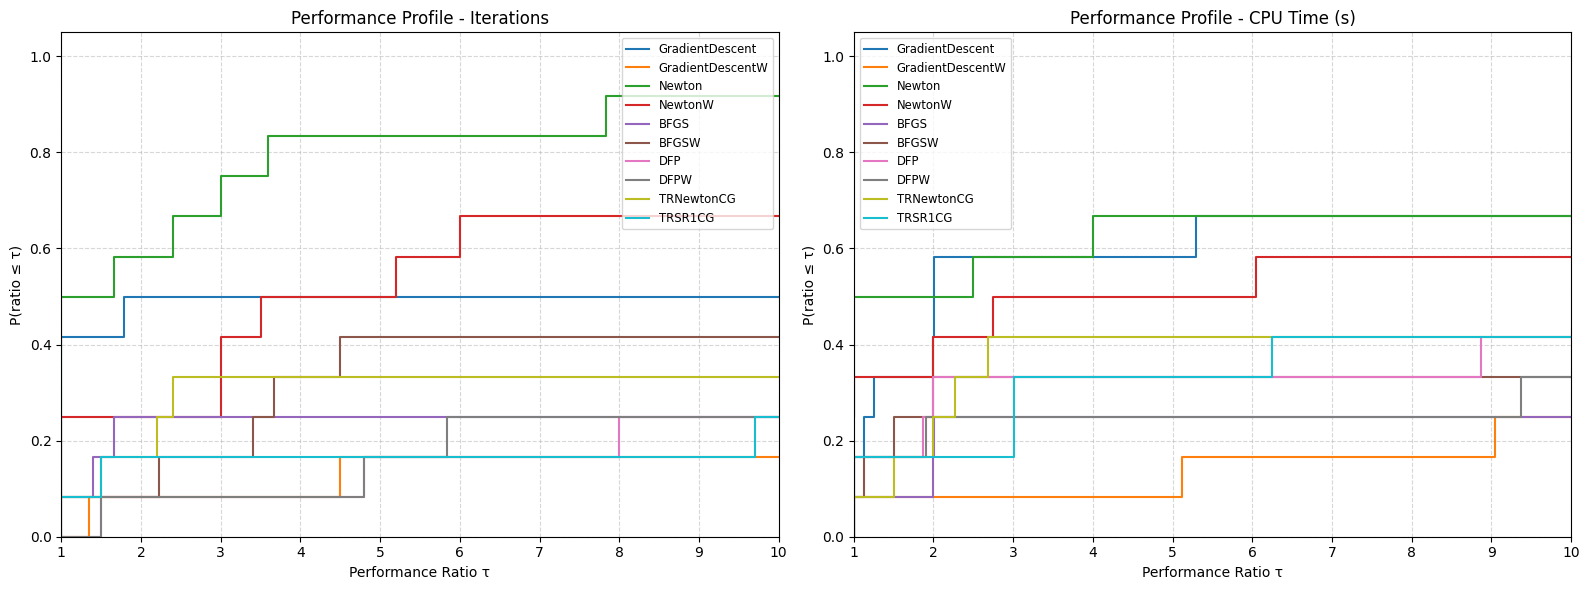

In [ ]:
from visualization import plot_convergence, calculate_performance_ratios, plot_profiles

# Call the convergence plot function
plot_convergence(detailed_info)

# Calculate performance ratios without success criteria
perf_ratios = calculate_performance_ratios(results, method_specs)

# Plot the performance profiles
plot_profiles(perf_ratios)